# Integrators errors
Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context
This example serves to showcase the different integrators implemented in Tudat.

For this example, only fixed step integration is carried, and all implemented integration coefficients are used. A list of these can be found in the API docs [here](https://py.api.tudat.space/en/latest/integrator.html#tudatpy.numerical_simulation.propagation_setup.integrator.CoefficientSets).

Then, the final error in position of each integrator is computed, comparing the final state to the exact analytical solution of a Keplerian orbit. This error is then shown as a function of the time step used for each integrator.

## Import statements
The required import statements are made here, at the very beginning.

Some standard modules are first loaded. These are `numpy`, `pandas`, and `matplotlib.pyplot`.

Then, the different modules of `tudatpy` that will be used are imported.

In [1]:
# TODO: the following two lines should be removed before pushing the final version online
import sys
sys.path.insert(0, "/cala/jeremie/tudat-bundle/build/tudatpy")

# Load standard modules
import numpy as np
import pandas as pd
# make plots interactive
%matplotlib widget
import matplotlib
from matplotlib import pyplot as plt

# Load tudatpy modules
from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.astro import element_conversion

## Configuration
NAIF's `SPICE` kernels are first loaded, so that the gravitational parameter of the Earth can be made known to `tudatpy`.

The simulation start epochs is then defined, followed by the definition of the massless satellite body "Delfi-C3" and of the Earth body.

In this step, the acceleration settings are also defined, consisting only in the Earth's gravitational acceleration modelled as a point mass. This means that the orbit that will be propagated is a Keplerian orbit, with no perturbations.

This setup is explained in more details in the dedicated **keplerian_satellite_orbit** example.

In [2]:
# Load spice kernels
spice.load_standard_kernels()

# Set simulation start and end epochs
simulation_start_epoch = 0.0

# Create default body settings for "Earth"
bodies_to_create = ["Earth"]

# Create default body settings for bodies_to_create, with "Earth"/"J2000" as the global frame origin and orientation
global_frame_origin = "Earth"
global_frame_orientation = "J2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

# Create system of bodies (in this case only Earth)
bodies = environment_setup.create_system_of_bodies(body_settings)

# Add vehicle object to system of bodies
bodies.create_empty_body("Delfi-C3")

# Define bodies that are propagated
bodies_to_propagate = ["Delfi-C3"]

# Define central bodies of propagation
central_bodies = ["Earth"]

# Define accelerations acting on Delfi-C3
acceleration_settings_delfi_c3 = dict(
    Earth=[propagation_setup.acceleration.point_mass_gravity()]
)
acceleration_settings = {"Delfi-C3": acceleration_settings_delfi_c3}

# Create acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies
)

## Initial state definition
The initial state is in this case defined by its Keplerian elements. Most importantly, the semi-major axis is of 7500km, and the eccentricity of 0.1.

These Keplerian elements are then converted to a Cartesian state using the `element_conversion.keplerian_to_cartesian_elementwise()` function.

Then, the orbital period is computed. This is because we want the simulation to end after exactly 30 orbits. This way, the final state of the massless satellite in a Keplerian orbit, should be equal to its initial state.

In [3]:
# Set initial conditions for the satellite that will be
# propagated in this simulation. The initial conditions are given in
# Keplerian elements and later on converted to Cartesian elements
initial_keplerian_elements = [7500e3, 0.1, np.deg2rad(85.3), np.deg2rad(235.7), np.deg2rad(23.4), np.deg2rad(139.87)]
earth_gravitational_parameter = bodies.get("Earth").gravitational_parameter
initial_state = element_conversion.keplerian_to_cartesian_elementwise(
    gravitational_parameter=earth_gravitational_parameter,
    semi_major_axis=initial_keplerian_elements[0],
    eccentricity=initial_keplerian_elements[1],
    inclination=initial_keplerian_elements[2],
    argument_of_periapsis=initial_keplerian_elements[3],
    longitude_of_ascending_node=initial_keplerian_elements[4],
    true_anomaly=initial_keplerian_elements[5]
)

# Compute the orbital period
period = np.pi * np.sqrt(initial_keplerian_elements[0]**3/earth_gravitational_parameter)

# Set the simulation end epoch as exactly 30 orbits
simulation_end_epoch = 30*period # ~27 hours

## Simulation setup

Let's now specify termination settings, to end the simulation after exaclty 30 orbits, and then assemble all of the settings into the propagation settings.

In [4]:
# Create termination settings, to end exactly after 30 orbits
termination_condition = propagation_setup.propagator.time_termination(
    simulation_end_epoch,
    terminate_exactly_on_final_condition=True)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    termination_condition
)

## Integrator setup
With the simulation now setup, we can focus on the integrators.

First, we define two lists with all of the integration coefficient sets that are available in Tudat.
These coefficients are split in the two lists depending on wether they contain only one integration order, or two.

Then, the `order_types` list is defined, containing keywords that define which integrators to try out. The keywords that contain "lower" or "higher" in parentheses indicate which order is to be used, if the integration coefficient set contains two orders.

Finally, a function is defined, `get_dts`. This function takes the type of coefficient set and its name as an input, and return the list of time steps that should be used for the given coefficient set.

**<u>Note</u>**: you are encouraged to play around with all of the lists and the function defined in the cell below (`single_order_coefficients`, `two_orders_coefficients`, `order_types`, `get_dts()`). This way, you can tune what steps to use, for which integration coefficients, and which coefficients to include or to skip.

In [5]:
single_order_coefficients = [
    # propagation_setup.integrator.euler_forward,
    propagation_setup.integrator.rk_4,
    propagation_setup.integrator.explicit_mid_point,
    propagation_setup.integrator.explicit_trapezoid_rule,
    propagation_setup.integrator.ralston,
    propagation_setup.integrator.rk_3,
    propagation_setup.integrator.ralston_3,
    propagation_setup.integrator.SSPRK3,
    propagation_setup.integrator.ralston_4,
    propagation_setup.integrator.three_eight_rule_rk_4
]

two_orders_coefficients = [
    propagation_setup.integrator.heun_euler,
    propagation_setup.integrator.rkf_12,
    propagation_setup.integrator.rkf_45,
    propagation_setup.integrator.rkf_56,
    propagation_setup.integrator.rkf_78,
    propagation_setup.integrator.rkdp_87,
    propagation_setup.integrator.rkf_89,
    propagation_setup.integrator.rkv_89,
    propagation_setup.integrator.rkf_108,
    propagation_setup.integrator.rkf_1210,
    propagation_setup.integrator.rkf_1412
]

# order_types = ["single order", "two orders (only lower)", "two orders (only higher)"]
order_types = ["two orders (only lower)", "two orders (only higher)"]

def get_dts(order_type, coeff_name, N=20):
    if order_type == "single order":
        if coeff_name == "euler_forward":
            return np.logspace(-0.5, -2.5, num=N)
        return np.logspace(2.0, -0.75, num=N)
    else:
        if coeff_name == "rkf_1412":
            if order_type == "two orders (only lower)":
                return np.logspace(2.6, 1.85, num=N)
            return np.logspace(2.6, 1.5, num=N)
        return np.logspace(2.5, 1.2, num=N)

## Run simulations

In [6]:
save_list = []

for order_type in order_types:
    order_to_use = propagation_setup.integrator.OrderToIntegrate.higher if "higher" in order_type else propagation_setup.integrator.OrderToIntegrate.lower
    coefficients_list = two_orders_coefficients if "two" in order_type else single_order_coefficients

    for coefficients in coefficients_list:
        coefficients_name = str(coefficients).split(".")[-1]
        
        for dt in get_dts(order_type, coefficients_name):
            print("Running %s coefficients (%s) with dt=%.2e s...                         " % (order_type, coefficients_name, dt), end="\r")
            integrator_settings = propagation_setup.integrator.runge_kutta_fixed_step_size(
                simulation_start_epoch, dt, coefficients, order_to_use
            )
            
            dynamics_simulator = numerical_simulation.SingleArcSimulator(
                bodies, integrator_settings, propagator_settings, print_state_data=False, print_dependent_variable_data=False
            )
            
            states = dynamics_simulator.state_history
            final_state = states[simulation_end_epoch]
            f_evals = list(dynamics_simulator.cumulative_number_of_function_evaluations.values())[-1]
            final_r_error = np.linalg.norm(final_state[0:3] - initial_state[0:3])
            
            # Do not go lower if numerical accuracy becomes too close to being an issue
            if final_r_error < 1e-4:
                break
            
            save_list.append([order_type, coefficients_name, dt, f_evals, final_r_error])
            
print("Done.")
save_list = np.asarray(save_list).T

Done.ng two orders (only higher) coefficients (rkf_1412) with dt=1.57e+02 s...                           


## Results analysis
Convert results to dataframe...

In [7]:
df_results = pd.DataFrame({
    "Order type": np.array(save_list[0,:], dtype=str),
    "Coefficients": np.array(save_list[1,:], dtype=str),
    "dt [s]": np.array(save_list[2,:], dtype=float),
    "Function evaluations": np.array(save_list[3,:], dtype=float),
    "Final position error [m]": np.array(save_list[4,:], dtype=float)
})
pd.set_option("display.precision", 3)
pd.set_option("display.min_rows", 15)
pd.set_option("display.max_rows", 30)
df_results

,Order type,Coefficients,dt [s],Function evaluations,Final position error [m]
0,two orders (only lower),heun_euler,316.228,614.0,9.732e+07
1,two orders (only lower),heun_euler,270.134,718.0,9.312e+07
2,two orders (only lower),heun_euler,230.759,842.0,5.249e+07
3,two orders (only lower),heun_euler,197.123,984.0,3.068e+07
4,two orders (only lower),heun_euler,168.390,1152.0,5.145e+07
5,two orders (only lower),heun_euler,143.845,1350.0,4.324e+07
6,two orders (only lower),heun_euler,122.878,1580.0,2.437e+07
...,...,...,...,...,...
287,two orders (only higher),rkf_1412,398.107,8540.0,1.215e+02
288,two orders (only higher),rkf_1412,348.422,9765.0,2.586e+01


Compute slope of each integrator...

In [8]:
save_analysis = []
# Loop trough values...
for order_type in df_results['Order type'].unique():
    df_this_order = df_results.loc[df_results['Order type'] == order_type]
    for coefficients_name in df_this_order['Coefficients'].unique():
        df_these_coefficients = df_this_order.loc[df_this_order['Coefficients'] == coefficients_name]
        
        # Compute slopes...
        f_evals_log = np.log10(list(df_these_coefficients["Function evaluations"]))
        pos_error_log = np.log10(list(df_these_coefficients["Final position error [m]"]))
        f_evals_range = [np.min(f_evals_log)*0.9, np.max(f_evals_log)*1.1]
        for i_refine in range(2):
            log_slopes = []
            log_intercepts = []
            for j in range(len(f_evals_log)-1):
                log_slopes.append((pos_error_log[j+1]-pos_error_log[j])/(f_evals_log[j+1]-f_evals_log[j]))
                log_intercepts.append(pos_error_log[j]-log_slopes[-1]*f_evals_log[j])
                
            # Remove nan values
            log_slopes = np.array(log_slopes)
            log_intercepts = np.array(log_intercepts)
            idx_nan_slopes = np.isnan(log_slopes)
            idx_nan_intercepts = np.isnan(log_intercepts)
            idx_nan = np.logical_or(idx_nan_slopes, idx_nan_intercepts)
            log_slopes = log_slopes[~np.isnan(idx_nan)]
            log_intercepts = log_intercepts[~np.isnan(idx_nan)]

            # Compute the median of the slopes
            slope_median = np.median(log_slopes)
            idx_slope_median = np.argmin(np.abs(log_slopes-slope_median))
            intercept_median = log_intercepts[idx_slope_median]

            # Compute line of best fit
            x_fit = np.logspace(f_evals_range[0], f_evals_range[1], num=len(f_evals_log))
            y_fit = np.asarray([10**(slope_median*np.log10(_fevals)+intercept_median) for _fevals in x_fit])

            if i_refine == 0:
                # Compute difference between line of best fit and original values
                fit_errors = np.log10(np.fabs(np.asarray(10**pos_error_log)-np.asarray(y_fit)))
                fit_errors_median = np.fabs(np.median(fit_errors))
                # Only keep values below the median
                to_keep_idx = np.where(fit_errors <= fit_errors_median)[0]

                # Remove the points that are not within the median
                pos_error_log = pos_error_log[to_keep_idx]
                f_evals_log = f_evals_log[to_keep_idx]
                
        save_analysis.append([order_type, coefficients_name, -slope_median, x_fit, y_fit])
        
save_analysis = np.asarray(save_analysis, dtype=object).T

Convert analysis to dataframe...

In [9]:
df_analysis = pd.DataFrame({
    "Order type": np.array(save_analysis[0,:], dtype=str),
    "Coefficients": np.array(save_analysis[1,:], dtype=str),
    "Slope": np.array(save_analysis[2,:], dtype=float),
    "x-fit": np.array(save_analysis[3,:], dtype=object),
    "y-fit": np.array(save_analysis[4,:], dtype=object),
})
pd.set_option("display.min_rows", 999)
df_analysis.drop("x-fit", axis=1).drop("y-fit", axis=1)

,Order type,Coefficients,Slope
0,two orders (only lower),heun_euler,0.331
1,two orders (only lower),rkf_12,0.829
2,two orders (only lower),rkf_45,5.511
3,two orders (only lower),rkf_56,5.001
4,two orders (only lower),rkf_78,6.990
5,two orders (only lower),rkdp_87,7.226
6,two orders (only lower),rkf_89,9.015
7,two orders (only lower),rkv_89,8.807
8,two orders (only lower),rkf_108,8.822
9,two orders (only lower),rkf_1210,8.575


Plot error vs f evals...

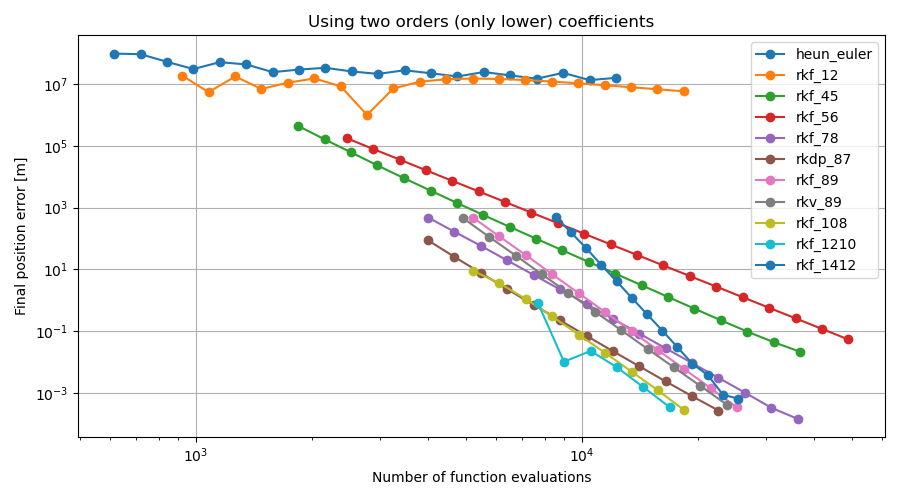

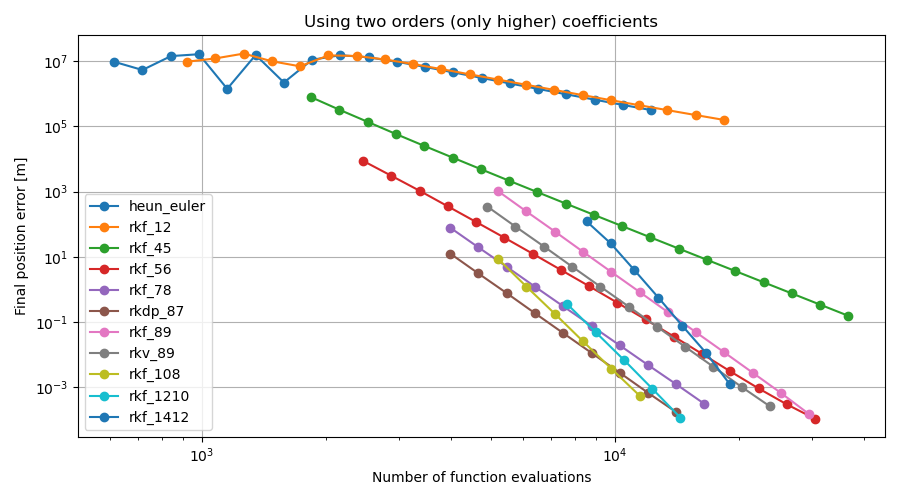

In [14]:
plot_fitted_lines = False

# Loop trough values...
for order_type in df_results['Order type'].unique():
    plt.figure(figsize=(9, 5))
    df_this_order = df_results.loc[df_results['Order type'] == order_type]
    i_col = 0
    for coefficients_name in df_this_order['Coefficients'].unique():
        df_these_coefficients = df_this_order.loc[df_this_order['Coefficients'] == coefficients_name]
        
        # Plot...
        plt.plot(
            df_these_coefficients["Function evaluations"],
            df_these_coefficients["Final position error [m]"],
            label=coefficients_name,
            marker="o",
            color="C%i"%i_col)
        
        if plot_fitted_lines:
            df_this_analysis = df_analysis.loc[df_analysis['Order type'] == order_type].loc[df_analysis['Coefficients'] == coefficients_name]
            plt.plot(
                list(df_this_analysis["x-fit"])[0],
                list(df_this_analysis["y-fit"])[0],
                linestyle="dotted",
                color="C%i"%i_col)
            
        i_col += 1
            
    plt.xlabel("Number of function evaluations")
    plt.ylabel("Final position error [m]")
    plt.legend()
    plt.grid()
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Using %s coefficients" % order_type)
    plt.tight_layout()
    plt.show()